# 2016 US Bike Share Activity - New York City, Chicago, and Washington, DC

## Table of Contents
- [Introduction](#intro)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction


Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I have performed an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I have compared the system usage between three large cities: New York City, Chicago, and Washington, DC. I have also investigated if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='wrangling'></a>
## Data Collection and Wrangling

In this project, I have focused on the record of individual trips taken in 2016 from three selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

Each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. The data is stored in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

I start off by looking at one entry from each of the cities I am going to analyze.

In [17]:
## import all necessary packages and functions
import csv
from datetime import datetime 
from pprint import pprint 
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## use the csv library to set up a DictReader object
        trip_reader = csv.DictReader(f_in)

        ## use a function on the DictReader object to read the
        ## first trip from the data file and store it in a variable
        first_trip = next(trip_reader)
        
        ## use the pprint library to print the first trip
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It is observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when I get to the actual exploration, I trim and clean the data.

I generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these requires additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. I use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, I convert the Washington labels to match the other two.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    """
    
    duration_format = {'NYC': 60,
                       'Chicago': 60,
                       'Washington': 60000}
    
    duration_name = {'NYC': 'tripduration',
                     'Chicago': 'tripduration',
                     'Washington': 'Duration (ms)'}
        
    return int(datum[duration_name[city]])/duration_format[city]


# Some tests to check that code works. There should be no output if all of
# the assertions pass
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """
    
    time_format = {'NYC': "%m/%d/%Y %H:%M:%S",
                   'Chicago': "%m/%d/%Y %H:%M",
                   'Washington': "%m/%d/%Y %H:%M"}
    
    time_name = {'NYC': 'starttime',
                 'Chicago': 'starttime',
                 'Washington': 'Start date'}
    
    date = datetime.strptime(datum[time_name[city]], time_format[city])
    month = date.month
    hour = date.hour
    day_of_week = calendar.day_name[date.weekday()]
    return (month, hour, day_of_week)


# Some tests to check that code works. There should be no output if all of
# the assertions pass
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [6]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    """

    # https://stackoverflow.com/a/9191474/7382214
    user_type = {'Registered': 'Subscriber', 'Casual': 'Customer'}
    
    return datum['usertype'] if (city != 'Washington') else user_type[datum['Member Type']]

# Some tests to check that code works. There should be no output if all of
# the assertions pass
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Now, I use the helper functions I wrote above to create a condensed data file for each city consisting only of the data fields indicated above.

In [8]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w', newline='') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## set up csv DictReader object
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## use the helper functions to get the cleaned data from
            ## the original data dictionaries
            ## keys for the new_point dictionary should match
            ## the column names set in the DictWriter object above
            
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month']=  time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)

            ## write the processed information to the output file
            trip_writer.writerow(new_point)

In [9]:
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that I have the data collected and wrangled, I am ready to start exploring the data. In this section I write some code to compute descriptive statistics from the data. 

<a id='statistics'></a>
### Statistics

First, I compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. 

This part answers the following questions:
* Which city has the highest number of trips?
* Which city has the highest proportion of trips made by subscribers?
* Which city has the highest proportion of trips made by short-term customers?

In [10]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # compute proportion of trips made by subscribers
        prop_subscribers = n_subscribers/n_total
        
        # compute proportion of trips made by short-term customers         
        prop_customers = n_customers/n_total
        
        # return tallies as a dictionary
        return {'Subscribers': n_subscribers, 'Customers': n_customers, 'Total': n_total, 'Prop_subscribers': prop_subscribers, 'Prop_customers': prop_customers}

In [11]:
data_files = {'Washington': './data/Washington-2016-Summary.csv',
              'Chicago': './data/Chicago-2016-Summary.csv',
              'NYC': './data/NYC-2016-Summary.csv'}

city_stats = {}
for city in data_files.keys():
    city_stats[city] = number_of_trips(data_files[city])

print(city_stats)

{'Washington': {'Subscribers': 51753, 'Customers': 14573, 'Total': 66326, 'Prop_subscribers': 0.7802822422579381, 'Prop_customers': 0.21971775774206193}, 'Chicago': {'Subscribers': 54982, 'Customers': 17149, 'Total': 72131, 'Prop_subscribers': 0.7622520136973008, 'Prop_customers': 0.23774798630269925}, 'NYC': {'Subscribers': 245896, 'Customers': 30902, 'Total': 276798, 'Prop_subscribers': 0.8883590199351151, 'Prop_customers': 0.11164098006488486}}


In [12]:
# getting max value for each key in nested dictionaries
# https://stackoverflow.com/a/33915886/7382214

def max_value(nested_dict, value_key):
    """
    This function takes a dictionary of dictionaries and outputs a max value for a given key (value_key).
    Key has to exist for nested dictionary.
    """
    max_value = max(nested_dict.items(), key=lambda v: float(nested_dict[v[0]][value_key]))
    return max_value[0], round(max_value[1][value_key],2)

print('{} has the highest number of trips: {}.'.format(*max_value(city_stats,'Total')))
print('{} has the highest proportion of trips made by subscribers: {}.'.format(*max_value(city_stats,'Prop_subscribers')))
print('{} has the highest proportion of trips made by short-term customers: {}.'.format(*max_value(city_stats,'Prop_customers')))

NYC has the highest number of trips: 276798.
NYC has the highest proportion of trips made by subscribers: 0.89.
Chicago has the highest proportion of trips made by short-term customers: 0.24.


Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. This part answers the following questions:

* What is the average trip length for each city?
* What proportion of rides made in each city are longer than 30 minutes?
* Which type of user takes longer rides on average: Subscribers or Customers?

In [15]:
def calc_trip_duration(filename):
    """
    This function takes a file with bike share data and returns the average trip length
    and percentage of trips that are longer than 30 minutes.
    """
    with open(filename,'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        trip_count = 0
        trip_length = 0
        trip_over30 = 0
        
        for row in reader:
            trip_count += 1
            duration = float(row['duration'])
            trip_length += duration
            if duration > 30:
                trip_over30 += 1
    
    return round(trip_length/trip_count,2), round((trip_over30/trip_count) * 100,2)
                  
for city in data_files.keys():
    print('In {}, the average trip duration is {} minutes and {}% of trips are longer than 30 minutes.'.format(city,*calc_trip_duration(data_files[city])))

In Washington, the average trip duration is 18.93 minutes and 10.84% of trips are longer than 30 minutes.
In Chicago, the average trip duration is 16.56 minutes and 8.33% of trips are longer than 30 minutes.
In NYC, the average trip duration is 15.81 minutes and 7.3% of trips are longer than 30 minutes.


In [12]:
def calc_trip_duration_user_type(filename):
    """
    This function takes a file with bike share data and returns the average trip length
    for subscribers and customers.
    """
    with open(filename) as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        trip_time_subscribers = 0
        trip_time_customers = 0
        trip_count_subscribers = 0
        trip_count_customers = 0
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                trip_count_subscribers += 1
                trip_time_subscribers += float(row['duration'])
            else:
                trip_count_customers += 1
                trip_time_customers += float(row['duration'])
        
        avg_trip_time_subscriber = trip_time_subscribers/trip_count_subscribers
        avg_trip_time_customer = trip_time_customers/trip_count_customers
        
    return round(avg_trip_time_subscriber,2), round(avg_trip_time_customer,2)

for city in data_files.keys():
    print("For {}, the average trip duration for Subscriber is {} minutes, while the average trip duration for Customer is {} minutes.".format(city, *calc_trip_duration_user_type(data_files[city])))

For Washington, the average trip duration for Subscriber is 12.53 minutes, while the average trip duration for Customer is 41.68 minutes.
For Chicago, the average trip duration for Subscriber is 12.07 minutes, while the average trip duration for Customer is 30.98 minutes.
For NYC, the average trip duration for Subscriber is 13.68 minutes, while the average trip duration for Customer is 32.78 minutes.


<a id='visualizations'></a>
### Visualizations

The last set of values that I computed pulles up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! 

It will be interesting to look at how the trip times are distributed. I start from a histogram of the trip times for all cities.

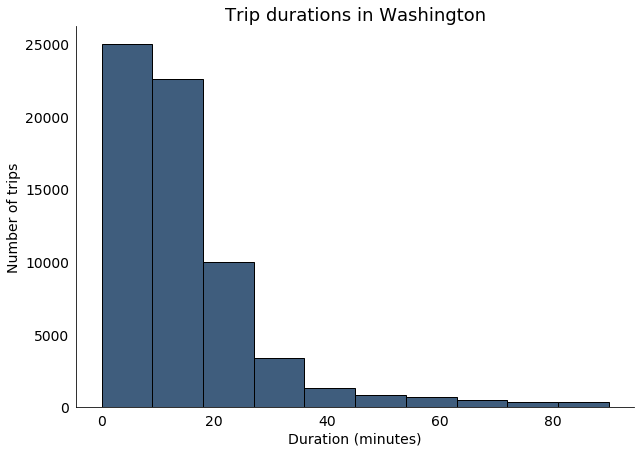

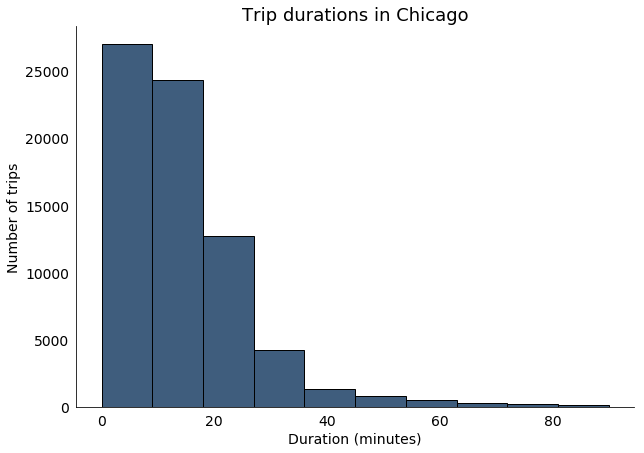

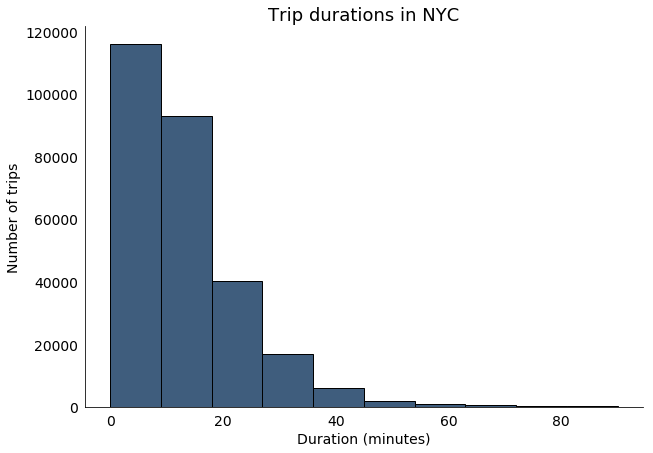

In [18]:
# collect data
def trip_times(filename):
    with open(filename) as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        # initialize count variable        
        data = []
        # save data in the list        
        for row in reader:
            data.append(float(row['duration']))
    return data

# plot hist function
def plot_hist(data, bins='auto', title='', xlabel='', ylabel='', plot_range=(0,100)):
    plt.figure(figsize=(10,7)) 

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)    

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 

    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True) 
    
    plt.hist(data, color="#3F5D7D", edgecolor="k", range=plot_range, bins=bins)
    plt.title(title,fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    plt.show()

# Plot data for each city
for city in data_files.keys():
    city_data = trip_times(data_files[city])
    plot_hist(data=city_data, bins=10, title='Trip durations in ' + city, xlabel='Duration (minutes)', ylabel='Number of trips', plot_range=(0,90))

Since there are some highly infrequent outliers in the data, I limit the range of data that is plotted.

Next, I plot separately the distribution of trip times for the Subscribers and Customers in the selected cities. Do the same thing for only the Customers. I limit the plots so that only trips of duration less than 75 minutes are plotted. Bars are in five-minute wide intervals.

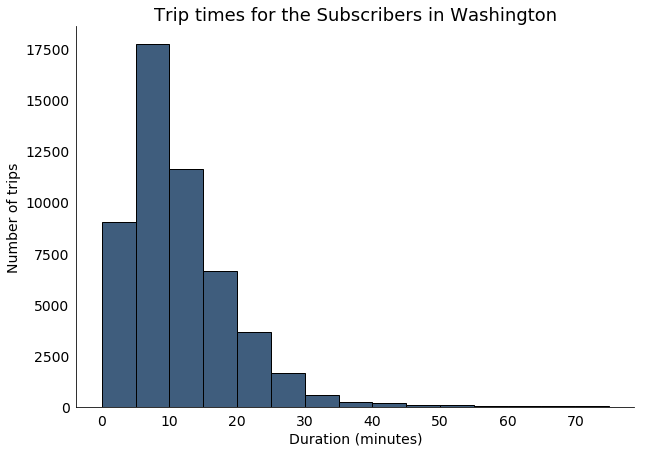

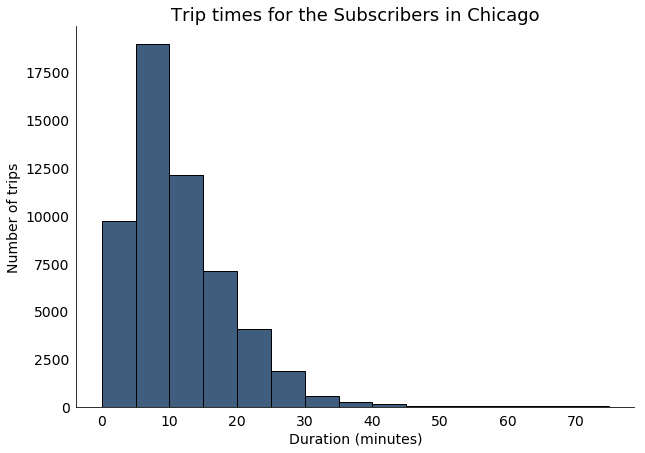

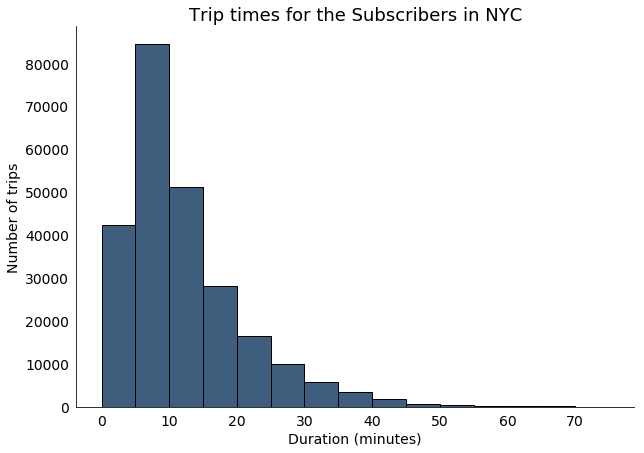

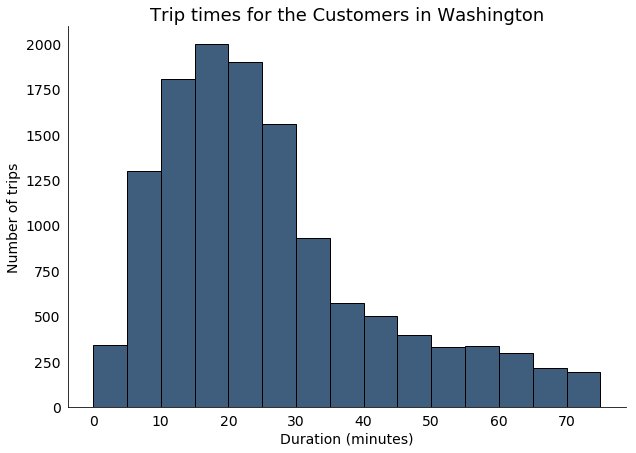

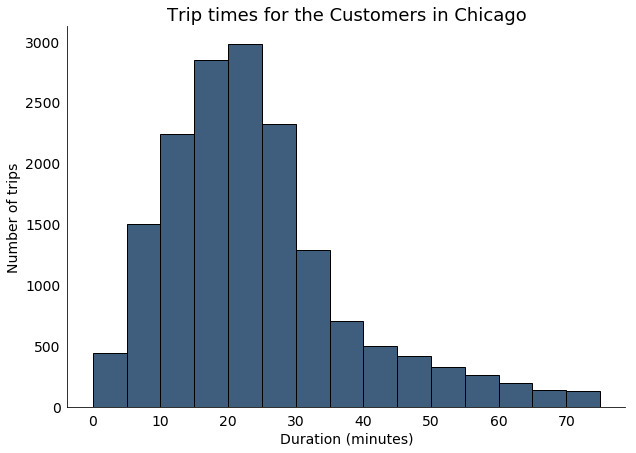

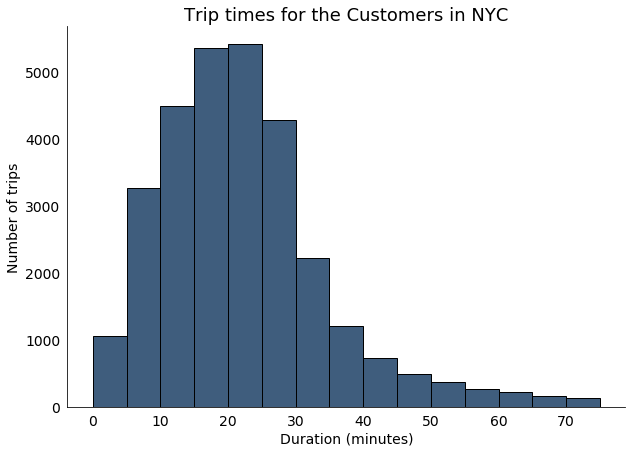

In [15]:
## Use this and additional cells to answer Question 5. ##
def calc_trip_duration(filename):
    with open(filename) as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        trip_time_subscribers = []
        trip_time_customers = []
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                trip_time_subscribers.append(float(row['duration']))
            else:
                trip_time_customers.append(float(row['duration']))
    return trip_time_subscribers, trip_time_customers

# Plot data for each city
for city in data_files.keys():
    city_subs_data = calc_trip_duration(data_files[city])[0]
    plot_hist(data=city_subs_data, bins=[i for i in range(0,76,5)], title='Trip times for the Subscribers in ' + city, xlabel='Duration (minutes)', ylabel='Number of trips', plot_range=(0,76))
    
# Plot data for each city
for city in data_files.keys():
    city_subs_data = calc_trip_duration(data_files[city])[1]
    plot_hist(data=city_subs_data, bins=[i for i in range(0,76,5)], title='Trip times for the Customers in ' + city, xlabel='Duration (minutes)', ylabel='Number of trips', plot_range=(0,76))
    

As we can see above, for Subscribers most of the trips are between 5 and 10 minutes, while for Customers most of the trips are between 15-25 minutes.

<a id='eda_continued'></a>
## Analysis

So far, I have performed an initial exploration into the data available. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now I continue the exploration to answer the following questions:

* How does ridership differ by month or season?
* Which month / season has the highest ridership?
* Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
* Is the pattern of ridership different on the weekends versus weekdays?
* On what days are Subscribers most likely to use the system? What about Customers?
* Does the average duration of rides change depending on the day of the week?
* During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

In [19]:
# plot bar chart
def plot_bar(data_cust_x, data_cust_y, data_sub_x, data_sub_y, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(12,9)) 

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)    
       
    plt.xticks(fontsize=14)

    plt.yticks(fontsize=14) 

    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True) 
    
    p1 = plt.bar(data_cust_x, data_cust_y, color="#ff7f0e", edgecolor="k")
    p2 = plt.bar(data_sub_x, data_sub_y, color="#3F5D7D", edgecolor="k", bottom=data_cust_y)
    
    plt.title(title,fontsize=18)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend((p1[0], p2[0]), ('Customers', 'Subscriber'), fontsize=14)
        
    plt.show()

In [20]:
# sort days
sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sorterIndex = dict(zip(sorter,range(len(sorter))))

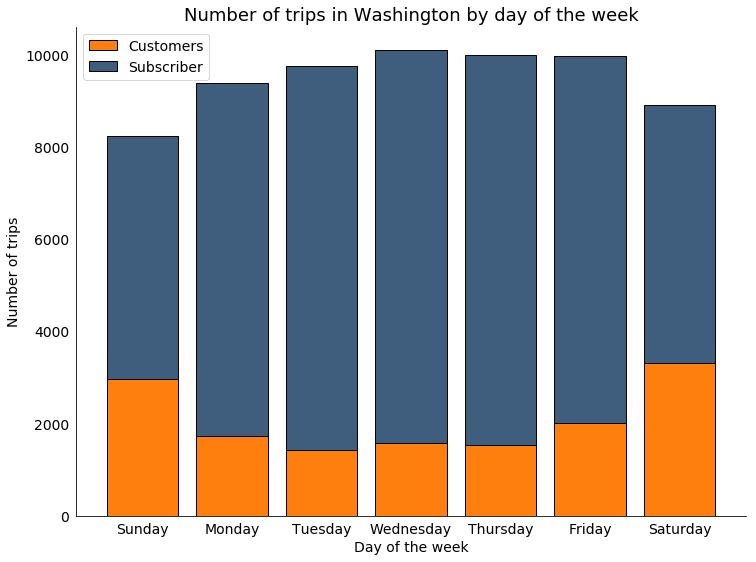

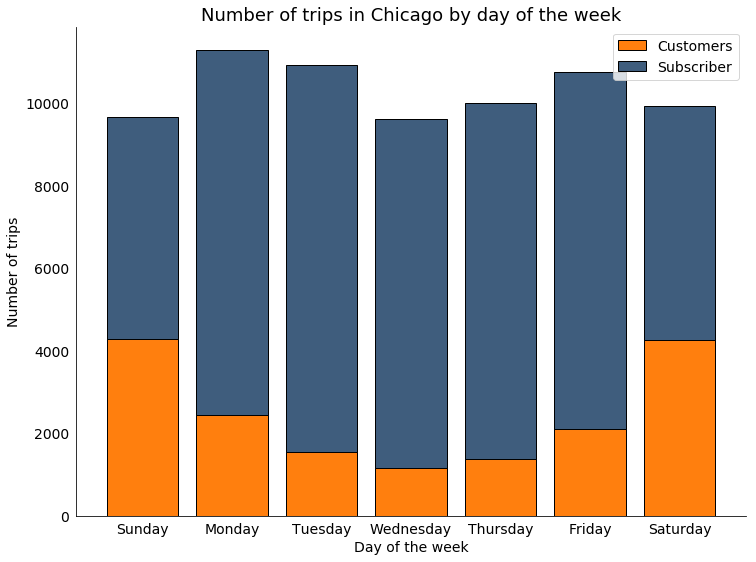

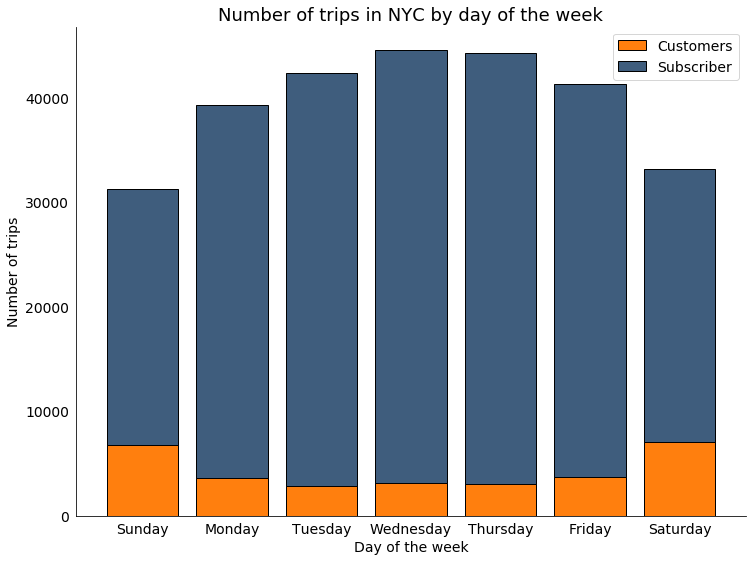

In [21]:
# plot day of week 
for city in data_files.keys():
    
    # read file with pandas     
    city_data = pd.read_csv(data_files[city])
    # display(city_data.head())
    
    # group data by day of the week     
    day_of_week = city_data.groupby(['user_type','day_of_week'], as_index=False).size().reset_index(name='Count')
   
    # sort data by day of the week, starting from Sunday
    day_of_week['day_id'] = day_of_week['day_of_week']
    day_of_week['day_id'] = day_of_week['day_id'].map(sorterIndex)
    day_of_week.sort_values('day_id', inplace=True)
    # display(day_of_week)
    
    # create mask to filter data    
    cust_mask = day_of_week['user_type'] == 'Customer'
    subs_mask = day_of_week['user_type'] == 'Subscriber'

    # plot data using bar chart     
    plot_bar(
        day_of_week[cust_mask]['day_of_week'],
        day_of_week[cust_mask]['Count'],
        day_of_week[subs_mask]['day_of_week'],
        day_of_week[subs_mask]['Count'],
        title='Number of trips in ' + city + ' by day of the week',
        xlabel='Day of the week',
        ylabel='Number of trips')

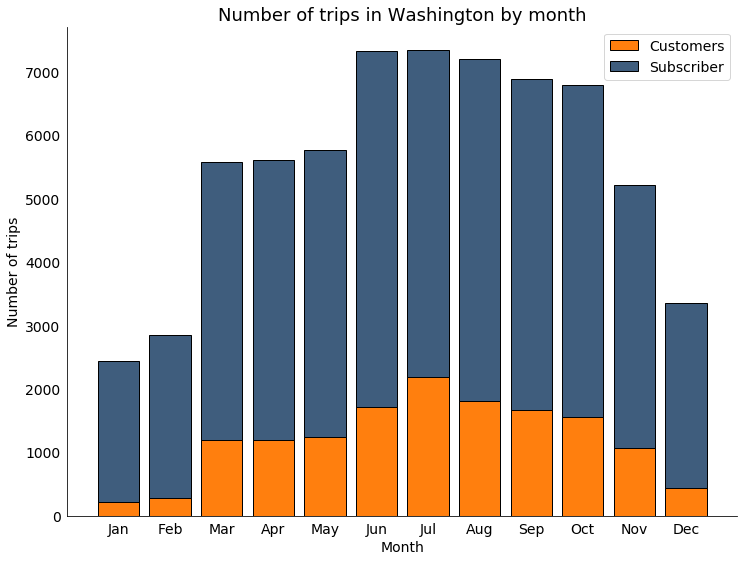

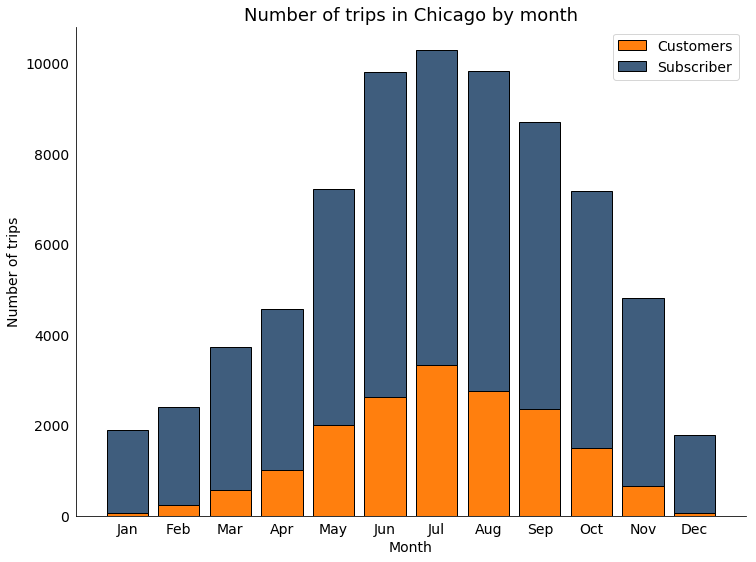

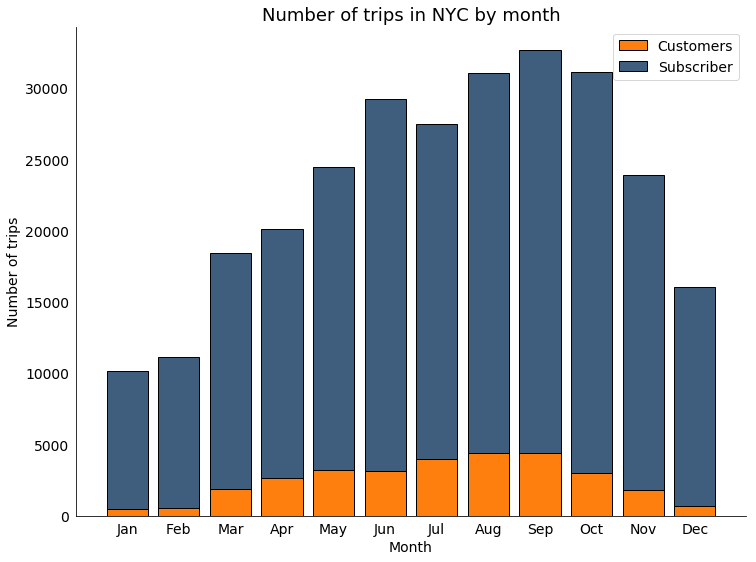

In [22]:
# plot month
for city in data_files.keys():
    
    # read file with pandas     
    city_data = pd.read_csv(data_files[city])
    # display(city_data.head())
    
    # group data by month
    month = city_data.groupby(['user_type','month'], as_index=False).size().reset_index(name='Count')
   
    # sort data by day of the week, starting from Sunday
    month['month_name'] = month['month']
    month['month_name'] = month['month_name'].apply(lambda x: calendar.month_abbr[x])
    month.sort_values('month', inplace=True)
    # display(month)
    
    # create mask to filter data    
    cust_mask = month['user_type'] == 'Customer'
    subs_mask = month['user_type'] == 'Subscriber'

    # plot data using bar chart     
    plot_bar(
        month[cust_mask]['month_name'],
        month[cust_mask]['Count'],
        month[subs_mask]['month_name'],
        month[subs_mask]['Count'],
        title='Number of trips in ' + city + ' by month',
        xlabel='Month',
        ylabel='Number of trips'
    )

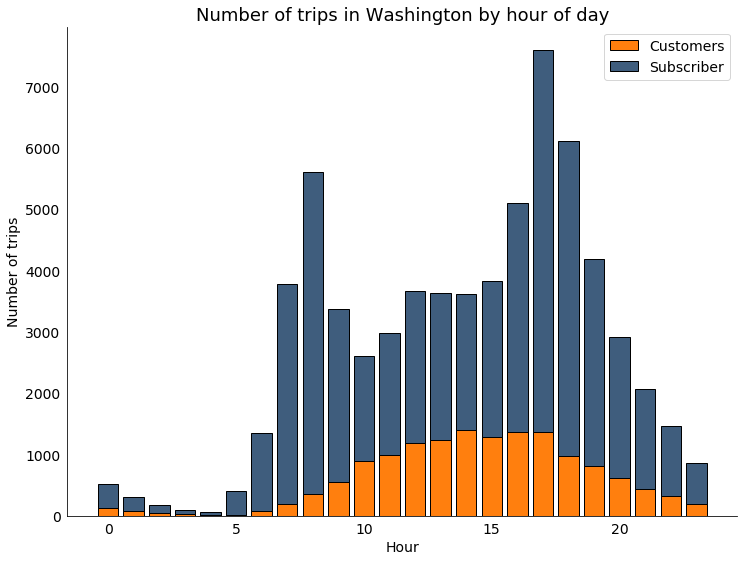

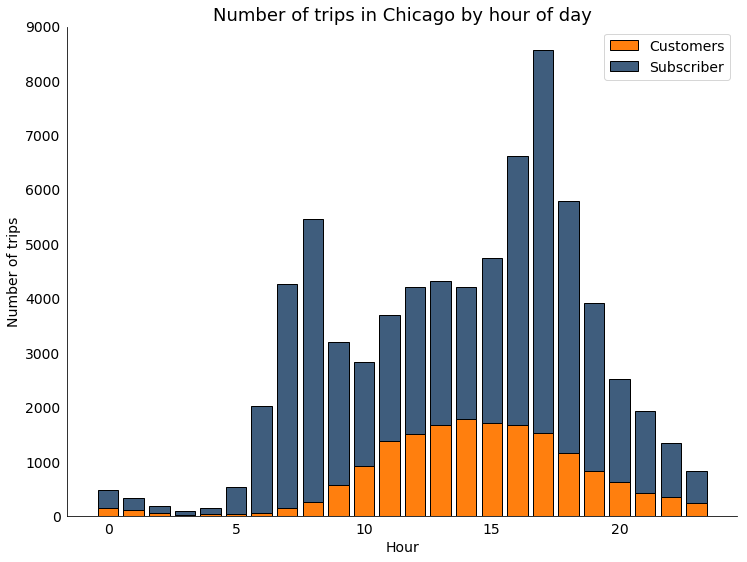

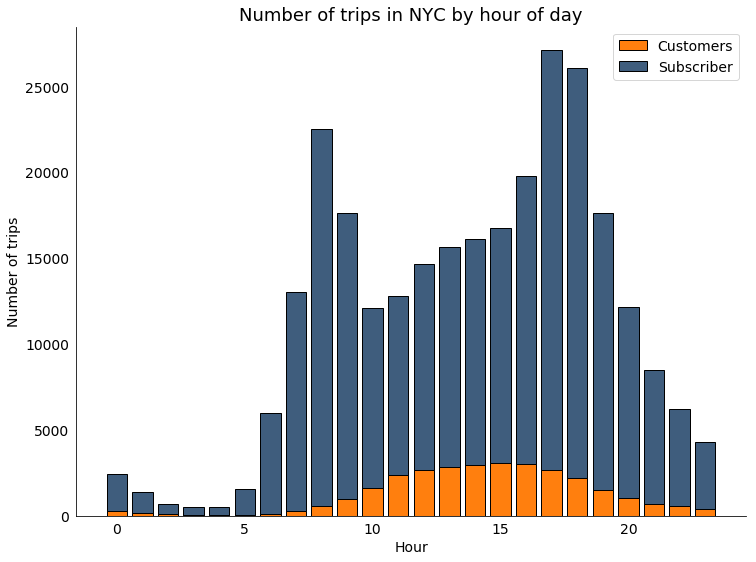

In [23]:
# plot hours
for city in data_files.keys():
    
    # read file with pandas     
    city_data = pd.read_csv(data_files[city])
    # display(city_data.head())
    
    # group data by hour
    hour = city_data.groupby(['user_type','hour'], as_index=False).size().reset_index(name='Count')
   
    # sort data
    hour.sort_values('hour', inplace=True)
    
    # create mask to filter data    
    cust_mask = hour['user_type'] == 'Customer'
    subs_mask = hour['user_type'] == 'Subscriber'

    # plot data using bar chart     
    plot_bar(
        hour[cust_mask]['hour'],
        hour[cust_mask]['Count'],
        hour[subs_mask]['hour'],
        hour[subs_mask]['Count'],
        title='Number of trips in ' + city + ' by hour of day',
        xlabel='Hour',
        ylabel='Number of trips'
    )

<a id='conclusions'></a>
## Conclusions

This analysis gives us a general picture of the collected data. There are a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])